In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import xarray as xr

import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from bs_fdbck.constants import path_extract_latlon_outdata
from dask.diagnostics import ProgressBar
import seaborn as sns

from bs_fdbck.util.imports import import_fields_xr_echam

import pandas as pd



from bs_fdbck.constants import measurements_path

from bs_fdbck.util.BSOA_datamanip import compute_total_tau, broadcase_station_data, change_units_and_compute_vars, \
    get_dic_df_mod, change_units_and_compute_vars_echam, extract_2D_cloud_time_echam, rn_dic_echam_cloud,rn_dic_noresm_cloud, rn_dic_obs_cloud

import datetime

from bs_fdbck.util.BSOA_datamanip import fix_echam_time

 from pathlib import Path 
 Path(path).mkdir(exist_ok=True, parents=True)
/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK/bs_fdbck/data_info/area_defs.csv


In [23]:
from pathlib import Path

from bs_fdbck.util.BSOA_datamanip import ds2df_inc_preprocessing
from bs_fdbck.util.collocate.collocateLONLAToutput import CollocateLONLATout
import useful_scit.util.log as log

from bs_fdbck.util.plot.BSOA_plots import make_cool_grid, plot_scatter

log.ger.setLevel(log.log.INFO)
import time
import xarray as xr
import matplotlib.pyplot as plt

In [4]:
xr.set_options(keep_attrs=True) 

## NorESM

In [5]:
lon_lims = [22.,30.]
lat_lims = [60.,66.]

lat_smr = 61.85
lon_smr = 24.28
model_lev_i=-1

temperature = 273.15  # K


from_time1 = '2012-01-01'
to_time1 = '2015-01-01'
from_time2 ='2015-01-01'
to_time2 ='2019-01-01'

In [6]:
case_name = 'OsloAero_intBVOC_f09_f09_mg17_fssp245'

case_name1 = 'OsloAero_intBVOC_f09_f09_mg17_full'
case_name2 = 'OsloAero_intBVOC_f09_f09_mg17_ssp245'

In [7]:
cases = [case_name]

### Path input data

In [8]:

path_input_data_noresm = path_extract_latlon_outdata/ case_name

### Filenames

In [9]:
fn1   = path_extract_latlon_outdata/case_name1/f'{case_name1}.h1._{from_time1}-{to_time1}_concat_subs_22.0-30.0_60.0-66.0.nc'

fn1_2 = fn1.parent / f'{fn1.stem}_sort.nc'

fn2   = path_extract_latlon_outdata/case_name2 /f'{case_name2}.h1._{from_time2}-{to_time2}_concat_subs_22.0-30.0_60.0-66.0.nc'

fn2_2 = fn2.parent / f'{fn2.stem}_sort.nc'

fn_comb                = path_input_data_noresm /f'{case_name}.h1._{from_time1}-{to_time2}_concat_subs_22.0-30.0_60.0-66.0.nc'
fn_comb_lev1           = path_input_data_noresm /f'{case_name}.h1._{from_time1}-{to_time2}_concat_subs_22.0-30.0_60.0-66.0_lev1.nc'
fn_comb_lev1_final     = path_input_data_noresm /f'{case_name}.h1._{from_time1}-{to_time2}_concat_subs_22.0-30.0_60.0-66.0_lev1_final.nc'
fn_comb_lev1_final_csv = path_input_data_noresm /f'{case_name}.h1._{from_time1}-{to_time2}_concat_subs_22.0-30.0_60.0-66.0_lev1_final_long_summer.csv'

### Station variables

In [10]:
varl_st = [      'SOA_NA','SOA_A1','OM_NI','OM_AI','OM_AC','SO4_NA','SO4_A1','SO4_A2','SO4_AC','SO4_PR',
      'BC_N','BC_AX','BC_NI','BC_A','BC_AI','BC_AC','SS_A1','SS_A2','SS_A3','DST_A2','DST_A3',
           'N50','N100', 'N150', 'N200', 
                 ]


varl_cl = ['TOT_CLD_VISTAU','TOT_ICLD_VISTAU','TGCLDCWP','TGCLDLWP','TGCLDIWP',
           'TOT_CLD_VISTAU_s','TOT_ICLD_VISTAU_s','optical_depth',
           'CLDFREE',
           'FCTL',
           'ACTREL','ACTNL','TGCLDLWP',
           'FSDSC','FSDSCDRF',
           'FCTI',
           'FCTL',
           'FLNS',
           'FLNSC',
           'FLNT',
           'FLNTCDRF',
           'FLNT_DRF',
           'FLUS',
           'FLUTC','FORMRATE',
           'FREQI',
           'FREQL',
           'FSDSCDRF',
           'FSDS_DRF',
           'FSNS',
           'FSNSC',
           'FSNT',
           'FSNTCDRF',
           'FSNT_DRF',
           'FSUS_DRF',
           'FSUTADRF',
           ]

### Read files and compute vertical variables, extract surface layer,  and merge timeseries

In [11]:
fn_comb#.exists()

PosixPath('/proj/bolinc/users/x_sarbl/analysis/Output_data_BS-FDBCK/extracted_latlon_subset/OsloAero_intBVOC_f09_f09_mg17_fssp245/OsloAero_intBVOC_f09_f09_mg17_fssp245.h1._2012-01-01-2019-01-01_concat_subs_22.0-30.0_60.0-66.0.nc')

In [12]:
if not fn_comb.exists():
    if (not fn1_2.exists()) or (not fn2_2.exists()):
        ds_mod1 = xr.open_dataset(fn1, chunks = {'time':96})#[fn1,fn2])#.sortby('time')
        ds_mod2 = xr.open_dataset(fn2, chunks = {'time':96})

        varl1 = set(ds_mod1.data_vars)

        varl2 = set(ds_mod2.data_vars)


        varl =list(varl1.intersection(varl2))

        ds_mod1 = ds_mod1[varl].sel(time=slice(sel_years_from_files[0],sel_years_from_files[1]))#.sortby('time')

        ds_mod2 = ds_mod2[varl].sel(time=slice(sel_years_from_files[2],sel_years_from_files[3]))#.sortby('time')
        print('HEEEEY')
        if not fn1_2.exists():
            delayed_obj = ds_mod1.to_netcdf(fn1_2, compute=False)
            with ProgressBar():
                results = delayed_obj.compute()
        if not fn2_2.exists():
            delayed_obj = ds_mod2.to_netcdf(fn2_2, compute=False)
            with ProgressBar():
                results = delayed_obj.compute()
    
    if not fn1_3.exists():
            ds_mod1 = xr.open_dataset(fn1_2, chunks = {'time':48})#[fn1,fn2])#.sortby('time')
            ds_mod1 = compute_total_tau(ds_mod1)
            ds_mod1 = ds_mod1.isel(lev = model_lev_i)
            ds_mod1 = ds_mod1.sortby('time')#.sel(time=slice('2012','2014'))
            delayed_obj = ds_mod1.to_netcdf(fn1_3, compute=False)
            print('hey 1')
            with ProgressBar():
                results = delayed_obj.compute()
    if not fn2_3.exists():
            ds_mod2 = xr.open_dataset(fn2_2, chunks = {'time':48})#[fn1,fn2])#.sortby('time')
            ds_mod2 = compute_total_tau(ds_mod2)
            ds_mod2 = ds_mod2.isel(lev = model_lev_i)
            ds_mod2 = ds_mod2.sortby('time')#.sel(time=slice('2012','2014'))
            delayed_obj = ds_mod2.to_netcdf(fn2_3, compute=False)
            print('hey')
            with ProgressBar():
                results = delayed_obj.compute()
    
    
    ds_mod = xr.open_mfdataset([fn1_3,fn2_3], combine='by_coords', concat_dim='time')

    fn_comb.parent.mkdir(exist_ok=True,)

    delayed_obj = ds_mod.to_netcdf(fn_comb, compute = False)
    with ProgressBar():
        results = delayed_obj.compute()

    #ds_mod = xr.concat([ds_mod1[varl].sel(time=slice('2012','2014')), ds_mod2[varl].sel(time=slice('2015','2018'))], dim='time')

### Check: 

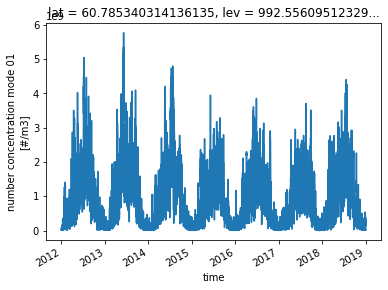

In [13]:
ds_mod = xr.open_dataset(fn_comb, chunks = {'time':48})
ds_mod['NCONC01'].isel(lat=0, lon=0).plot()

### Broadcast station variables to every gridcell and manipulate units etc

We use only hyytiala for org etc, but all grid cells over finland for cloud properties

In [14]:
if not fn_comb_lev1_final.exists():
    ds_all = xr.open_dataset(fn_comb).isel(ilev=model_lev_i)
    ds_sel = ds_all.sel(lat = lat_smr, lon= lon_smr, method='nearest')#.isel( ilev=model_lev_i)#.load()
    ds_all = ds_all.isel(
             nbnd=0
    ).squeeze()
    ds_all = broadcase_station_data(ds_all)
    ds_all = change_units_and_compute_vars(ds_all, temperature=temperature)


    delayed_obj = ds_all.to_netcdf(fn_comb_lev1_final, compute=False)
    print('hey')
    with ProgressBar():
        results = delayed_obj.compute()

### Add Nx values! 

In [18]:

varl_tmp =['N50','N100','N150','N200',
      #'SOA_NA','SOA_A1','OM_NI','OM_AI','OM_AC','SO4_NA','SO4_A1','SO4_A2','SO4_AC','SO4_PR',
      #'BC_N','BC_AX','BC_NI','BC_A','BC_AI','BC_AC','SS_A1','SS_A2','SS_A3','DST_A2','DST_A3', 
      ] 

In [27]:
for case_name in [case_name1]:
    varlist = varl_tmp
    c = CollocateLONLATout(case_name, from_time1, to_time1,
                           True,
                           'hour',
                           history_field='.h1.')
    if c.check_if_load_raw_necessary(varlist ):
        time1 = time.time()
        a = c.make_station_data_merge_monthly(varlist)
        print(a)

        time2 = time.time()
        print('DONE : took {:.3f} s'.format( (time2-time1)))
    else:
        print('UUUPS')

for case_name in [case_name2]:
    varlist = varl_tmp# list_sized_vars_noresm
    c = CollocateLONLATout(case_name, from_time2, to_time2,
                           False,
                           'hour',
                           history_field='.h1.')
    if c.check_if_load_raw_necessary(varlist ):
        time1 = time.time()
        a = c.make_station_data_merge_monthly(varl_tmp)
        print(a)

        time2 = time.time()
        print('DONE : took {:.3f} s'.format( (time2-time1)))
    else:
        print('UUUPS')

In [30]:
dic_ds = dict()
for ca in [case_name1]:
    c = CollocateLONLATout(ca, from_time1, to_time1,
                           False,
                           'hour',
                           history_field='.h1.')
    ds = c.get_collocated_dataset(varl_tmp)
    if 'location' in ds.coords:
        ds = ds.rename({'location':'station'})
    dic_ds[ca]=ds

2022-06-14 17:56:03,925 useful_scit  INFO     Opening: [//proj/bolinc/users/x_sarbl/analysis/Output_data_BS-FDBCK/collocated_ds/NorESM/OsloAero_intBVOC_f09_f09_mg17_full/N50_OsloAero_intBVOC_f09_f09_mg17_full_2012-01-01_2015-01-01_hour_locations.nc,//proj/bolinc/users/x_sarbl/analysis/Output_data_BS-FDBCK/collocated_ds/NorESM/OsloAero_intBVOC_f09_f09_mg17_full/N100_OsloAero_intBVOC_f09_f09_mg17_full_2012-01-01_2015-01-01_hour_locations.nc,//proj/bolinc/users/x_sarbl/analysis/Output_data_BS-FDBCK/collocated_ds/NorESM/OsloAero_intBVOC_f09_f09_mg17_full/N150_OsloAero_intBVOC_f09_f09_mg17_full_2012-01-01_2015-01-01_hour_locations.nc,//proj/bolinc/users/x_sarbl/analysis/Output_data_BS-FDBCK/collocated_ds/NorESM/OsloAero_intBVOC_f09_f09_mg17_full/N200_OsloAero_intBVOC_f09_f09_mg17_full_2012-01-01_2015-01-01_hour_locations.nc]


//proj/bolinc/users/x_sarbl/analysis/Output_data_BS-FDBCK/collocated_ds/NorESM/OsloAero_intBVOC_f09_f09_mg17_full/N50_OsloAero_intBVOC_f09_f09_mg17_full_2012-01-01_2015-01-01_hour_locations.nc
//proj/bolinc/users/x_sarbl/analysis/Output_data_BS-FDBCK/collocated_ds/NorESM/OsloAero_intBVOC_f09_f09_mg17_full/N100_OsloAero_intBVOC_f09_f09_mg17_full_2012-01-01_2015-01-01_hour_locations.nc
//proj/bolinc/users/x_sarbl/analysis/Output_data_BS-FDBCK/collocated_ds/NorESM/OsloAero_intBVOC_f09_f09_mg17_full/N150_OsloAero_intBVOC_f09_f09_mg17_full_2012-01-01_2015-01-01_hour_locations.nc
//proj/bolinc/users/x_sarbl/analysis/Output_data_BS-FDBCK/collocated_ds/NorESM/OsloAero_intBVOC_f09_f09_mg17_full/N200_OsloAero_intBVOC_f09_f09_mg17_full_2012-01-01_2015-01-01_hour_locations.nc
2022-06-14 17:56:03,925 useful_scit  INFO     Opening: [//proj/bolinc/users/x_sarbl/analysis/Output_data_BS-FDBCK/collocated_ds/NorESM/OsloAero_intBVOC_f09_f09_mg17_full/N50_OsloAero_intBVOC_f09_f09_mg17_full_2012-01-01_2015-

In [35]:
#dic_ds = dict()
for ca in [case_name2]:
    c = CollocateLONLATout(ca, from_time2, to_time2,
                           False,
                           'hour',
                           history_field='.h1.')
    ds = c.get_collocated_dataset(varl_tmp)
    if 'location' in ds.coords:
        ds = ds.rename({'location':'station'})
    dic_ds[ca]=ds

2022-06-14 17:57:23,103 useful_scit  INFO     Opening: [//proj/bolinc/users/x_sarbl/analysis/Output_data_BS-FDBCK/collocated_ds/NorESM/OsloAero_intBVOC_f09_f09_mg17_ssp245/N50_OsloAero_intBVOC_f09_f09_mg17_ssp245_2015-01-01_2019-01-01_hour_locations.nc,//proj/bolinc/users/x_sarbl/analysis/Output_data_BS-FDBCK/collocated_ds/NorESM/OsloAero_intBVOC_f09_f09_mg17_ssp245/N100_OsloAero_intBVOC_f09_f09_mg17_ssp245_2015-01-01_2019-01-01_hour_locations.nc,//proj/bolinc/users/x_sarbl/analysis/Output_data_BS-FDBCK/collocated_ds/NorESM/OsloAero_intBVOC_f09_f09_mg17_ssp245/N150_OsloAero_intBVOC_f09_f09_mg17_ssp245_2015-01-01_2019-01-01_hour_locations.nc,//proj/bolinc/users/x_sarbl/analysis/Output_data_BS-FDBCK/collocated_ds/NorESM/OsloAero_intBVOC_f09_f09_mg17_ssp245/N200_OsloAero_intBVOC_f09_f09_mg17_ssp245_2015-01-01_2019-01-01_hour_locations.nc]


//proj/bolinc/users/x_sarbl/analysis/Output_data_BS-FDBCK/collocated_ds/NorESM/OsloAero_intBVOC_f09_f09_mg17_ssp245/N50_OsloAero_intBVOC_f09_f09_mg17_ssp245_2015-01-01_2019-01-01_hour_locations.nc
//proj/bolinc/users/x_sarbl/analysis/Output_data_BS-FDBCK/collocated_ds/NorESM/OsloAero_intBVOC_f09_f09_mg17_ssp245/N100_OsloAero_intBVOC_f09_f09_mg17_ssp245_2015-01-01_2019-01-01_hour_locations.nc
//proj/bolinc/users/x_sarbl/analysis/Output_data_BS-FDBCK/collocated_ds/NorESM/OsloAero_intBVOC_f09_f09_mg17_ssp245/N150_OsloAero_intBVOC_f09_f09_mg17_ssp245_2015-01-01_2019-01-01_hour_locations.nc
//proj/bolinc/users/x_sarbl/analysis/Output_data_BS-FDBCK/collocated_ds/NorESM/OsloAero_intBVOC_f09_f09_mg17_ssp245/N200_OsloAero_intBVOC_f09_f09_mg17_ssp245_2015-01-01_2019-01-01_hour_locations.nc
2022-06-14 17:57:23,103 useful_scit  INFO     Opening: [//proj/bolinc/users/x_sarbl/analysis/Output_data_BS-FDBCK/collocated_ds/NorESM/OsloAero_intBVOC_f09_f09_mg17_ssp245/N50_OsloAero_intBVOC_f09_f09_mg17_ssp

In [39]:
case1 = case_name1
case2 = case_name2

ds1 = dic_ds[case1]
ds2 = dic_ds[case2]


st_y = from_time1.split('-')[0]
mid_y_t = str(int(to_time1.split('-')[0])-1)
mid_y_f = to_time1.split('-')[0]
end_y = to_time2.split('-')[0]

print(st_y, mid_y_t, mid_y_f, end_y)

_ds1 = ds1.sel(time=slice(st_y, mid_y_t))
_ds2 = ds2.sel(time=slice(mid_y_f, end_y))
ds_comb_station = xr.concat([_ds1, _ds2], dim='time')#.sortby('time')

2012 2014 2015 2019


In [46]:
ds_comb_SMR = ds_comb_station.sel(station='SMR').isel(lev=-1)

In [47]:
ds_comb_SMR

<xarray.Dataset>
Dimensions:  (time: 61345)
Coordinates:
    lev      float64 992.6
  * time     (time) datetime64[ns] 2012-01-02 2012-01-02T01:00:00 ... 2019-01-01
    station  <U3 'SMR'
Data variables:
    N100     (time) float64 dask.array<chunksize=(26280,), meta=np.ndarray>
    N150     (time) float64 dask.array<chunksize=(26280,), meta=np.ndarray>
    N200     (time) float64 dask.array<chunksize=(26280,), meta=np.ndarray>
    N50      (time) float64 dask.array<chunksize=(26280,), meta=np.ndarray>

In [40]:
fn_comb_lev1.exists()

True

In [43]:
from bs_fdbck.util.BSOA_datamanip import broadcast_vars_in_ds_sel

In [49]:
varl_tmp

['N50', 'N100', 'N150', 'N200']

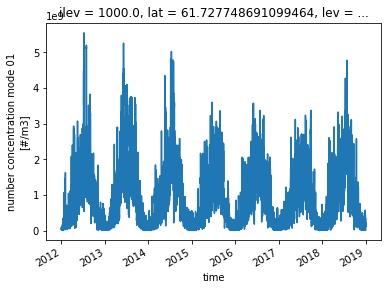

In [16]:

ds_all = xr.open_dataset(fn_comb_lev1_final)

ds_all['NCONC01'].isel(lat=1, lon=1).plot()

In [72]:
ds_smll = ds_all[['NCONC01']]

In [73]:
ds_smll = broadcast_vars_in_ds_sel(ds_smll, ds_comb_SMR, varl_tmp, only_already_in_ds= False)

N50
N100
N150
N200


In [74]:
ds_smll#['N100']


<xarray.Dataset>
Dimensions:  (time: 61344, lat: 6, lon: 7)
Coordinates:
  * time     (time) datetime64[ns] 2012-01-02 ... 2018-12-31T23:00:00
    ilev     float64 1e+03
  * lat      (lat) float64 60.79 61.73 62.67 63.61 64.55 65.5
    lev      float64 992.6
  * lon      (lon) float64 22.5 23.75 25.0 26.25 27.5 28.75 30.0
    station  <U3 'SMR'
Data variables:
    NCONC01  (time, lat, lon) float32 1.918e+07 2.582e+07 ... 1.806e+07
    N50      (time, lat, lon) float64 dask.array<chunksize=(26280, 6, 7), meta=np.ndarray>
    N100     (time, lat, lon) float64 dask.array<chunksize=(26280, 6, 7), meta=np.ndarray>
    N150     (time, lat, lon) float64 dask.array<chunksize=(26280, 6, 7), meta=np.ndarray>
    N200     (time, lat, lon) float64 dask.array<chunksize=(26280, 6, 7), meta=np.ndarray>
Attributes:
    Conventions:       CF-1.0
    source:            CAM
    case:              OsloAero_intBVOC_f09_f09_mg17_full
    logname:           x_sarbl
    host:              
    initial_file:      spinup_freemet_f09_f09_mg17_from2000.cam.i.2011-01-01-...
    topography_file:   /proj/cesm_input-data/inputdata/noresm-only/inputForNu...
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    time_period_freq:  hour_1
    history:           Mon Apr 11 21:44:12 2022: ncrcat /proj/bolinc/users/x_...
    NCO:               netCDF Operators version 4.7.9 (Homepage = http://nco....

In [75]:
for v in varl_tmp:
    ds_all[v] = ds_smll[v]

### Finally produce daily median dataframe:

In [76]:
dic_ds = dict()
dic_ds[case_name] =ds_all

In [77]:
from timeit import default_timer as timer



In [78]:
fn_comb_lev1_final_csv

PosixPath('/proj/bolinc/users/x_sarbl/analysis/Output_data_BS-FDBCK/extracted_latlon_subset/OsloAero_intBVOC_f09_f09_mg17_fssp245/OsloAero_intBVOC_f09_f09_mg17_fssp245.h1._2012-01-01-2019-01-01_concat_subs_22.0-30.0_60.0-66.0_lev1_final_long_summer.csv')

In [79]:
if not fn_comb_lev1_final_csv.exists():
    start = timer()
    for key in dic_ds:
        dic_ds[key] = dic_ds[key].rename(rn_dic_noresm_cloud)

    dic_df = get_dic_df_mod(dic_ds, select_hours_clouds=True, summer_months=[6,7,8,9])

    df_mod = dic_df[case_name]
    df_mod.to_csv(fn_comb_lev1_final_csv)
    end = timer()
    print(end - start) # Time in seconds, e.g. 5.38091952400282
    print(f'DONE! That took {(end-start)} seconds')    
    print(f'That is  {((end-start)/60)} minuts')

<xarray.Dataset>
Dimensions:            (time: 61344, lat: 6, lon: 7)
Coordinates:
    ilev               float64 1e+03
  * lat                (lat) float64 60.79 61.73 62.67 63.61 64.55 65.5
    lev                float64 992.6
  * lon                (lon) float64 22.5 23.75 25.0 26.25 27.5 28.75 30.0
  * time               (time) datetime64[ns] 2012-01-02 ... 2018-12-31T23:00:00
    station            <U3 'SMR'
Data variables: (12/197)
    NMR13              (time, lat, lon) float32 ...
    nscur              (time) int32 0 3600 7200 10800 ... 75600 79200 82800
    hybm               (time) float64 0.9926 0.9926 0.9926 ... 0.9926 0.9926
    T                  (time, lat, lon) float32 ...
    EC550AER           (time, lat, lon) float32 ...
    FLNS               (time, lat, lon) float32 ...
    ...                 ...
    optical_depth      (time, lat, lon) float32 ...
    transmittance      (time, lat, lon) float32 ...
    N50                (time, lat, lon) float64 dask.array<chunks

/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1119: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


492.1237069480121
DONE! That took 492.1237069480121 seconds
That is  8.202061782466869 minuts


## ECHAM-SALSA

### Names etc

In [20]:

case_name = 'SALSA_BSOA_feedback'
case_name_echam = 'SALSA_BSOA_feedback'
time_res = 'hour'
space_res='locations'
model_name='ECHAM-SALSA'
model_name_echam  ='ECHAM-SALSA'

### Input path:

In [21]:
input_path_echam = path_extract_latlon_outdata / model_name_echam / case_name_echam 

In [22]:

cases_echam = [case_name_echam]

### Station variables  and others

In [23]:
varl_st_echam = [
    'mmrtrN500',
    'mmrtrN250',
    'mmrtrN200',
    'mmrtrN100',
    'mmrtrN50',
    'mmrtrN3',
    'SO2_gas',
    'APIN_gas',
    'TBETAOCI_gas',
    'BPIN_gas',
    'LIMON_gas',
    'SABIN_gas',
    'MYRC_gas',
    'CARENE3_gas',
    'ISOP_gas',
    'VBS0_gas',
    'V*BS1_gas',
    'VBS10_gas',
    'ORG_mass',
    'oh_con',
    'tempair',
    'ccn02',
    'ccn10',
]


varl_cl_echam = [
    'airdens',
    'uw',
    'vw',
    'cod',
    'cwp',
    'ceff',
    'ceff_ct',
    #'ceff_ct_incl',
    'lcdnc',
    'lcdnc_ct',
    'clfr',
    'cl_time',
    'aot550nm',
    'up_sw',
    'up_sw_cs',
    'up_sw_noa',
    'up_sw_cs_noa',
    'up_lw',
    'up_lw_cs',
    'up_lw_noa',
    'up_lw_cs_noa',
    'emi_monot_bio',
    'emi_isop_bio',
]

### Define some strings for files

In [24]:

str_from_t = pd.to_datetime(from_time1).strftime('%Y%m')
str_to = pd.to_datetime(to_time2).strftime('%Y%m')
str_lonlim = '%.1f-%.1f'%(*lon_lims,)
str_latlim = '%.1f-%.1f'%(*lat_lims,)
str_coordlims = f'{str_lonlim}_{str_latlim}'
str_coordlims

'22.0-30.0_60.0-66.0'

### Filenames: 

In [25]:
fn_final_echam = input_path_echam / f'{case_name}_{from_time1}-{to_time2}_ALL-VARS_concat_subs_{str_coordlims}.nc'
fn_final_echam_csv = input_path_echam / f'{case_name}_{from_time1}-{to_time2}_ALL-VARS_concat_subs_{str_coordlims}_long_summer.csv'

### Open data

In [26]:
fl_open = []

for v in varl_cl_echam+ varl_st_echam:
    fn = input_path_echam / f'{case_name}_{from_time1}-{to_time2}_{v}_concat_subs_{str_coordlims}.nc'
    if fn.exists():
        fl_open.append(fn)

In [27]:
len(fl_open)

29

### Open files, decode time, drop excess coords, select bottom layer, broadcast station vars to whole grid and compute units etc

In [28]:
if not fn_final_echam.exists():
    ds_all = xr.open_mfdataset(fl_open, decode_cf = False)
    #ds_iso = xr.open_dataset(fl_open[21])
    #ds = xr.merge([ds_iso,ds])
    ds_all = import_fields_xr_echam.decode_cf_echam(ds_all)




    #ds_all = import_fields_xr_echam.decode_cf_echam(ds_all)
    ds_all = extract_2D_cloud_time_echam(ds_all) 



    #ds_sel = ds_all.sel(lat = lat_smr, lon= lon_smr, method='nearest').isel( lev=model_lev_i)#.load()
    ds_all = ds_all.squeeze()
    ds_all=ds_all.drop(['hyai','hybi','hyam','hybm']).squeeze()
    ds_all = ds_all.isel( lev=model_lev_i)
    

    ds_all = broadcase_station_data(ds_all, varl_st=varl_st_echam)
    

    ds_all = change_units_and_compute_vars_echam(ds_all)

    delayed_obj = ds_all.to_netcdf(fn_final_echam, compute=False)
    print('hey')
    with ProgressBar():
        results = delayed_obj.compute()

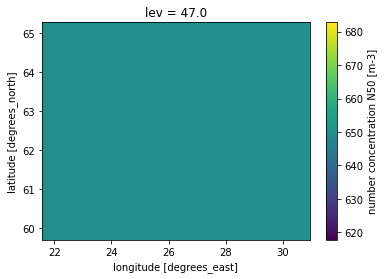

In [29]:
ds_all = xr.open_dataset(fn_final_echam)
ds_all['N50'].mean('time').plot()#.isel(lat=0, time=0).plot()#.shape#.plot()

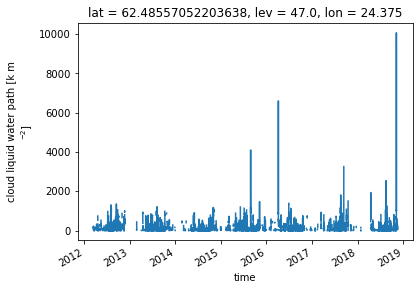

In [30]:
ds_all['cwp_incld'].isel(lat=1, lon=1).plot()

### Fix time for echam

In [31]:
ds_all['time'] = ds_all['time'].to_dataframe()['time'].apply(fix_echam_time).values

In [32]:
ds_all['cwp']

<xarray.DataArray 'cwp' (time: 61368, lat: 3, lon: 5)>
[920520 values with dtype=float32]
Coordinates:
  * lat      (lat) float64 64.35 62.49 60.62
    lev      float64 ...
  * lon      (lon) float64 22.5 24.38 26.25 28.12 30.0
  * time     (time) datetime64[ns] 2012-01-01 ... 2018-12-31T23:00:00
Attributes:
    long_name:    cloud liquid water path
    units:        k m $^{-2}$
    description:  cloud liquid water path

### Finally produce daily median dataframe:

In [33]:
dic_ds = dict()
dic_ds[case_name] =ds_all

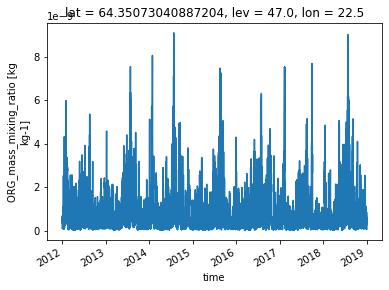

In [34]:
ds_all['ORG_mass'].isel(lat=0,lon=0).plot()

In [35]:
fn_final_echam_csv

PosixPath('/proj/bolinc/users/x_sarbl/analysis/Output_data_BS-FDBCK/extracted_latlon_subset/ECHAM-SALSA/SALSA_BSOA_feedback/SALSA_BSOA_feedback_2012-01-01-2019-01-01_ALL-VARS_concat_subs_22.0-30.0_60.0-66.0_long_summer.csv')

(array([8.24097e+05, 3.35250e+04, 3.48550e+04, 1.68620e+04, 7.47700e+03,
        2.58700e+03, 7.18000e+02, 2.59000e+02, 1.07000e+02, 3.30000e+01]),
 array([ 0.       ,  3.7184072,  7.4368143, 11.155221 , 14.873629 ,
        18.592035 , 22.310442 , 26.028849 , 29.747257 , 33.465664 ,
        37.18407  ], dtype=float32),
 <BarContainer object of 10 artists>)

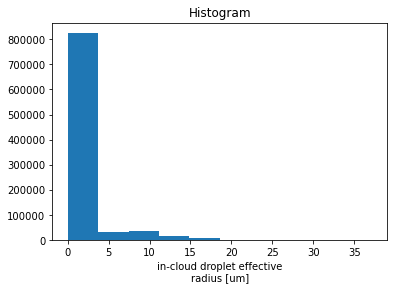

In [36]:
ds_all['ceff_um'].plot()

In [37]:
import numpy as np

(array([ 4968.,  6415.,  6882., 11346., 14474., 16865., 17025., 14507.,
        11071.,  8634.,  6935.,  3911.,  1597.,   912.,   695.,   530.,
          363.,   300.,   233.]),
 array([ 0.        ,  1.57894737,  3.15789474,  4.73684211,  6.31578947,
         7.89473684,  9.47368421, 11.05263158, 12.63157895, 14.21052632,
        15.78947368, 17.36842105, 18.94736842, 20.52631579, 22.10526316,
        23.68421053, 25.26315789, 26.84210526, 28.42105263, 30.        ]),
 <BarContainer object of 19 artists>)

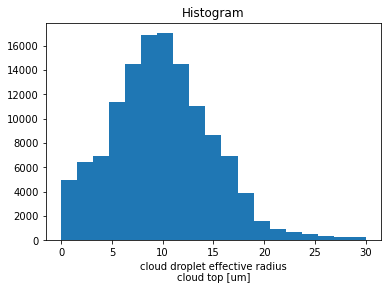

In [38]:
ds_all['ceff_ct_incld'].plot(bins = np.linspace(0,30,20))

(array([7.92902e+05, 9.41100e+03, 8.68600e+03, 1.22660e+04, 1.50390e+04,
        1.73790e+04, 1.71820e+04, 1.45280e+04, 1.08390e+04, 8.29800e+03,
        6.49600e+03, 3.55300e+03, 1.35400e+03, 7.49000e+02, 5.39000e+02,
        4.05000e+02, 2.57000e+02, 1.89000e+02, 1.37000e+02]),
 array([ 0.        ,  1.57894737,  3.15789474,  4.73684211,  6.31578947,
         7.89473684,  9.47368421, 11.05263158, 12.63157895, 14.21052632,
        15.78947368, 17.36842105, 18.94736842, 20.52631579, 22.10526316,
        23.68421053, 25.26315789, 26.84210526, 28.42105263, 30.        ]),
 <BarContainer object of 19 artists>)

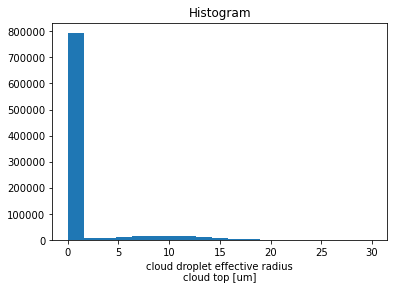

In [39]:
ds_all['ceff_ct'].plot(bins = np.linspace(0,30,20))

(array([54022., 20007., 12737.,  9310.,  7004.,  5353.,  4377.,  3092.,
         2452.,  2096.,  1692.,  1306.,   982.,   835.,   711.,   552.,
          406.,   339.,   286.]),
 array([   0.        ,   52.63157895,  105.26315789,  157.89473684,
         210.52631579,  263.15789474,  315.78947368,  368.42105263,
         421.05263158,  473.68421053,  526.31578947,  578.94736842,
         631.57894737,  684.21052632,  736.84210526,  789.47368421,
         842.10526316,  894.73684211,  947.36842105, 1000.        ]),
 <BarContainer object of 19 artists>)

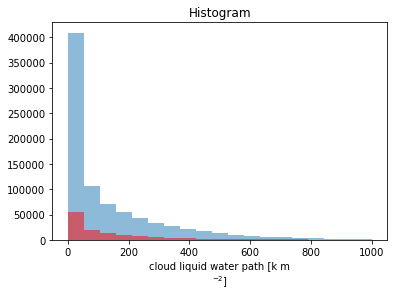

In [40]:
ds_all['cwp'].plot(bins=np.linspace(0,1000,20),alpha=.5, )

ds_all['cwp_incld'].plot(bins=np.linspace(0,1000,20), alpha=.5, color='r')

In [41]:
rn_dic_echam_cloud

{'cwp_incld': 'CWP', 'cod_incld': 'COT', 'ceff_ct_incld': 'r_eff'}

In [43]:
if not fn_final_echam_csv.exists():
    for key in dic_ds:
        dic_ds[key] = dic_ds[key].rename(rn_dic_echam_cloud)

    dic_df = get_dic_df_mod(dic_ds, select_hours_clouds=True, summer_months=[6,7,8,9])

    df_mod = dic_df[case_name]
    df_mod.to_csv(fn_final_echam_csv)

<xarray.Dataset>
Dimensions:           (time: 61368, lat: 3, lon: 5)
Coordinates:
  * lat               (lat) float64 64.35 62.49 60.62
    lev               float64 47.0
  * lon               (lon) float64 22.5 24.38 26.25 28.12 30.0
  * time              (time) datetime64[ns] 2012-01-01 ... 2018-12-31T23:00:00
Data variables: (12/45)
    ORG_mass          (time, lat, lon) float32 ...
    airdens           (time, lat, lon) float32 ...
    aot550nm          (time, lat, lon) float32 ...
    ccn02             (time, lat, lon) float32 ...
    ccn10             (time, lat, lon) float32 ...
    ceff              (time, lat, lon) float32 ...
    ...                ...
    N200              (time, lat, lon) float32 ...
    OA                (time, lat, lon) float32 ...
    cwp               (time, lat, lon) float32 ...
    CWP               (time, lat, lon) float32 ...
    lcdnc_cm3         (time, lat, lon) float32 ...
    T_C               (time, lat, lon) float32 ...
Attributes:
    CDI:   

In [43]:
_df = pd.read_csv(fn_comb_lev1_final_csv, index_col=0)#[_df['isSummer'].notnull()]

In [44]:
_df = _df[_df['isSummer'].notnull()]

In [45]:
pd.to_datetime(_df.index).month.unique()

Int64Index([6, 7, 8, 9], dtype='int64', name='time')

In [46]:
fn_comb_lev1_final_csv

PosixPath('/proj/bolinc/users/x_sarbl/analysis/Output_data_BS-FDBCK/extracted_latlon_subset/OsloAero_intBVOC_f09_f09_mg17_fssp245/OsloAero_intBVOC_f09_f09_mg17_fssp245.h1._2012-01-01-2019-01-01_concat_subs_22.0-30.0_60.0-66.0_lev1_final_long_summer.csv')

In [47]:
fn_final_echam_csv

PosixPath('/proj/bolinc/users/x_sarbl/analysis/Output_data_BS-FDBCK/extracted_latlon_subset/ECHAM-SALSA/SALSA_BSOA_feedback/SALSA_BSOA_feedback_2012-01-01-2019-01-01_ALL-VARS_concat_subs_22.0-30.0_60.0-66.0_long_summer.csv')

## EXTRA

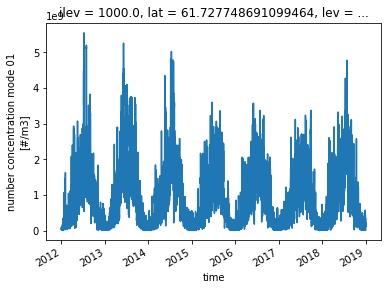

In [48]:

ds_all = xr.open_dataset(fn_comb_lev1_final)

ds_all['NCONC01'].isel(lat=1, lon=1).plot()

In [49]:
ds_all['OA'].attrs['units'] = 'ug'

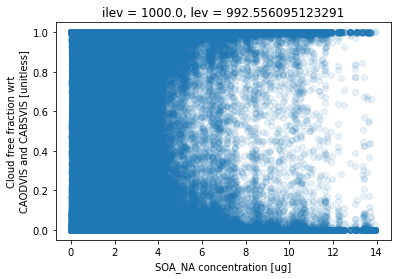

In [50]:
ds_all.plot.scatter(x='OA',y='CLDFREE', alpha=0.1)

In [51]:
ds_all['TOT_CLD_VISTAU_s_incld']

<xarray.DataArray 'TOT_CLD_VISTAU_s_incld' (time: 61344, lat: 6, lon: 7)>
[2576448 values with dtype=float32]
Coordinates:
    ilev     float64 1e+03
  * lat      (lat) float64 60.79 61.73 62.67 63.61 64.55 65.5
    lev      float64 992.6
  * lon      (lon) float64 22.5 23.75 25.0 26.25 27.5 28.75 30.0
  * time     (time) datetime64[ns] 2012-01-02 ... 2018-12-31T23:00:00
Attributes:
    mdims:              1
    Sampling_Sequence:  rad_lwsw
    units:              1
    long_name:          Total gbx cloud extinction visible sw optical depth
    cell_methods:       time: mean

In [52]:
ds_all['month'] = ds_all['time.month']

In [53]:
ma = ((ds_all['TGCLDCWP_incld']<200 ) & (ds_all['TGCLDCWP_incld']>150 ) )& (ds_all['time.hour']<16 ) & (ds_all['time.hour']>10 ) 
ma = ma & ( (ds_all['month']>=6 ) &(ds_all['month']<=8 ))

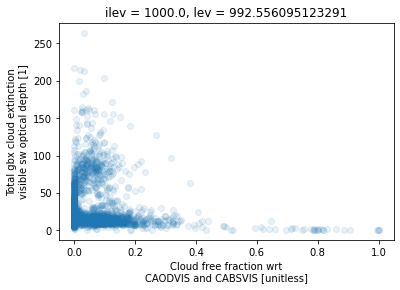

In [54]:
ds_all.where(ma).plot.scatter(x='CLDFREE',y='TOT_CLD_VISTAU_s_incld', alpha=0.1,)

In [55]:
ds_m = ds_all#.where(ma)

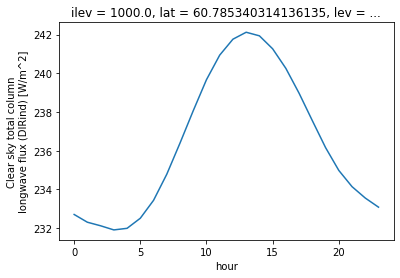

In [56]:
ds_m.isel(lat=0, lon = 0).groupby(ds_m['time.hour']).mean()['FLNTCDRF'].plot()

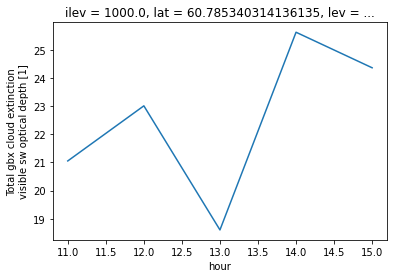

In [57]:
ds_m.where(ma).isel(lat=0, lon = 0).groupby(ds_m['time.hour']).mean()['TOT_CLD_VISTAU_s_incld'].plot()

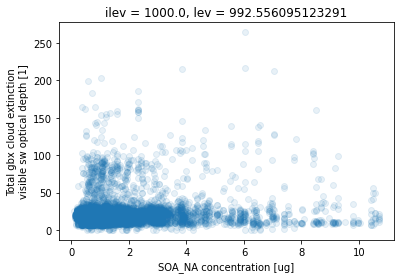

In [58]:
ds_all.where(ma).plot.scatter(x='OA',y='TOT_CLD_VISTAU_s_incld', alpha=0.1,)

In [59]:
ds_all['hour'] = ds_all['time.hour']
ds_all['month'] = ds_all['time.month']

(0.0, 100.0)

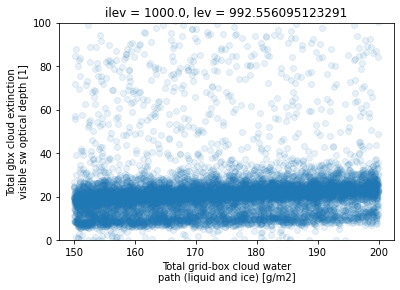

In [60]:
ds_all.where(ma).plot.scatter(x='TGCLDCWP_incld',y='TOT_CLD_VISTAU_s_incld', alpha=0.1)
plt.ylim([0,100])

(0.0, 100.0)

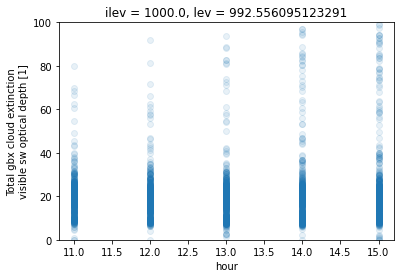

In [61]:
ds_all.where((ma&(ds_all['month']==8))).plot.scatter(x='hour',y='TOT_CLD_VISTAU_s_incld', alpha=0.1)
plt.ylim([0,100])

(0.0, 100.0)

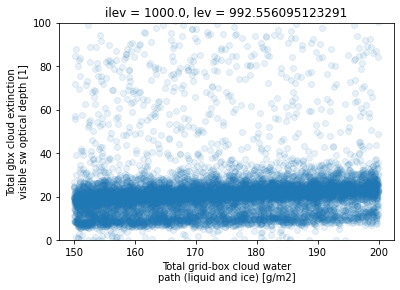

In [62]:
ds_all.where(ma).plot.scatter(x='TGCLDCWP_incld',y='TOT_CLD_VISTAU_s_incld', alpha=0.1)
plt.ylim([0,100])

(0.0, 100.0)

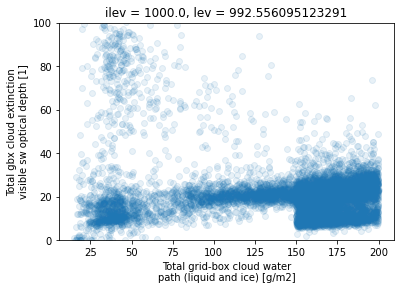

In [63]:
ds_all.where(ma).plot.scatter(x='TGCLDCWP',y='TOT_CLD_VISTAU_s_incld', alpha=0.1)
plt.ylim([0,100])

(0.0, 100.0)

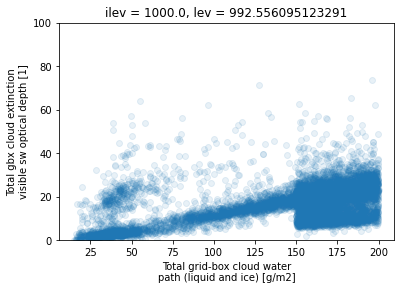

In [64]:
ds_all.where(ma).plot.scatter(x='TGCLDCWP',y='TOT_CLD_VISTAU_s', alpha=0.1)
plt.ylim([0,100])

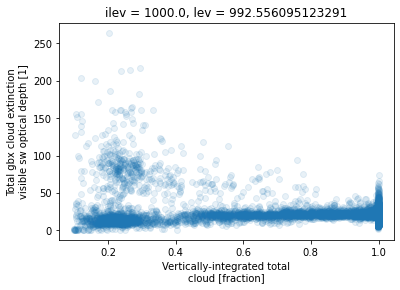

In [65]:
ds_all.where(ma).plot.scatter(x='CLDTOT',y='TOT_CLD_VISTAU_s_incld', alpha=0.1,)

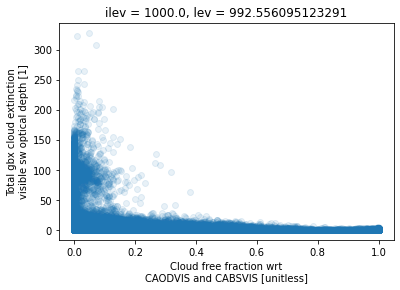

In [66]:
ds_all.where((ds_all['time.hour']<15) & (ds_all['time.hour']>10) ).plot.scatter(x='CLDFREE',y='TOT_CLD_VISTAU_s_incld', alpha=0.1,)

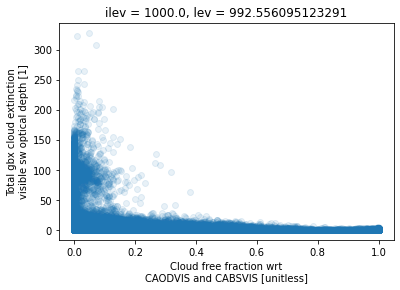

In [67]:
ds_all.where((ds_all['time.hour']<15) & (ds_all['time.hour']>10) ).plot.scatter(x='CLDFREE',y='TOT_CLD_VISTAU_s_incld', alpha=0.1,)

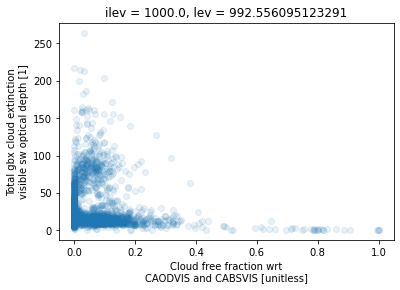

In [68]:
ds_all.where(ma).plot.scatter(x='CLDFREE',y='TOT_CLD_VISTAU_s_incld', alpha=0.1,)

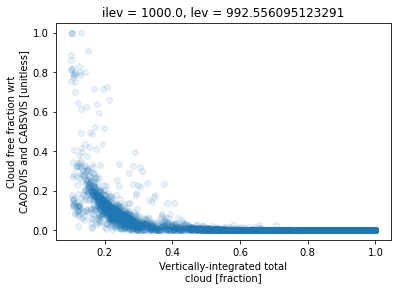

In [69]:
ds_all.where(ma).plot.scatter(x='CLDTOT',y='CLDFREE', alpha=0.1,)

(array([46695.,   810.,   565.,   429.,   371.,   485.,   489.,   558.,
          685., 10257.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ],
       dtype=float32),
 <BarContainer object of 10 artists>)

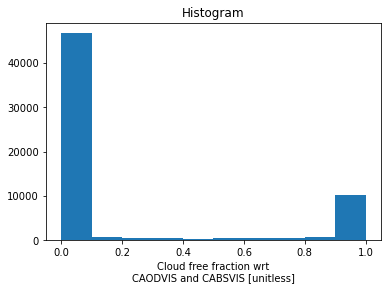

In [70]:
ds_all['CLDFREE'].sel(lat=lat_smr, lon  = lon_smr, method = 'nearest').plot.hist()

(array([11818.,  1523.,  1435.,  1142.,  1251.,  1367.,  1431.,  1612.,
         2317., 37448.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ],
       dtype=float32),
 <BarContainer object of 10 artists>)

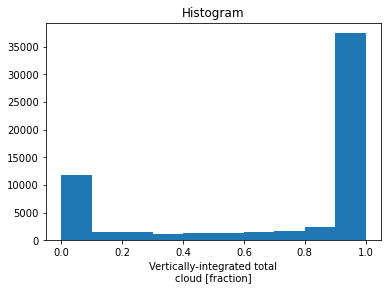

In [71]:
ds_all['CLDTOT'].sel(lat=lat_smr, lon  = lon_smr, method = 'nearest').plot.hist()

In [72]:
_f = '/proj/bolinc/users/x_sarbl/noresm_archive/OsloAero_intBVOC_f09_f09_mg17_ssp245/atm/hist/OsloAero_intBVOC_f09_f09_mg17_ssp245.cam.h1.2015-07-02-00000.nc'

In [73]:
_ds = xr.open_dataset(_f) 

In [74]:
_ds['CLDFREE'].sel(lat=lat_smr, lon = lon_smr, method = 'nearest')

<xarray.DataArray 'CLDFREE' (time: 48)>
array([2.408590e-05, 4.498383e-07, 1.174623e-06, 2.100671e-04, 9.235305e-04,
       9.745454e-04, 7.886373e-02, 3.719872e-01, 8.580465e-02, 2.529004e-03,
       2.154407e-04, 1.145442e-03, 9.973761e-01, 1.000000e+00, 1.000000e+00,
       9.712232e-01, 3.579029e-07, 0.000000e+00, 0.000000e+00, 0.000000e+00,
       0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
       0.000000e+00, 0.000000e+00, 0.000000e+00, 2.109304e-12, 6.976523e-04,
       5.029481e-04, 8.559549e-04, 5.312985e-04, 2.115685e-04, 3.770964e-03,
       1.737006e-01, 9.985011e-01, 1.000000e+00, 1.000000e+00, 1.000000e+00,
       1.000000e+00, 1.000000e+00, 1.000000e+00, 1.000000e+00, 1.000000e+00,
       4.160559e-01, 7.355484e-05, 0.000000e+00], dtype=float32)
Coordinates:
    lat      float64 61.73
    lon      float64 23.75
  * time     (time) datetime64[ns] 2015-07-02 ... 2015-07-03T23:00:00
Attributes:
    units:         unitless
    long_name:     Cloud free fraction wrt CAODVIS and CABSVIS
    cell_methods:  time: mean

In [75]:
_ds['CLDTOT'].sel(lat=lat_smr, lon = lon_smr, method = 'nearest')

<xarray.DataArray 'CLDTOT' (time: 48)>
array([5.176895e-01, 6.023937e-01, 5.315539e-01, 3.919072e-01, 3.771299e-01,
       3.394506e-01, 1.029906e-01, 8.298458e-02, 1.746608e-01, 3.435282e-01,
       4.099123e-01, 2.843383e-01, 1.320965e-04, 2.331468e-15, 1.765255e-14,
       5.118690e-02, 8.136247e-01, 9.990000e-01, 9.990000e-01, 9.990000e-01,
       9.990000e-01, 9.990000e-01, 9.990000e-01, 9.990000e-01, 9.990000e-01,
       9.990000e-01, 9.990000e-01, 9.990000e-01, 7.921399e-01, 4.671490e-01,
       4.957304e-01, 4.727387e-01, 5.151839e-01, 5.153781e-01, 3.230993e-01,
       1.005681e-01, 5.000000e-05, 0.000000e+00, 0.000000e+00, 0.000000e+00,
       0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00, 5.609593e-05,
       1.441483e-01, 7.895206e-01, 9.990000e-01], dtype=float32)
Coordinates:
    lat      float64 61.73
    lon      float64 23.75
  * time     (time) datetime64[ns] 2015-07-02 ... 2015-07-03T23:00:00
Attributes:
    units:         fraction
    long_name:     Vertically-integrated total cloud
    cell_methods:  time: mean

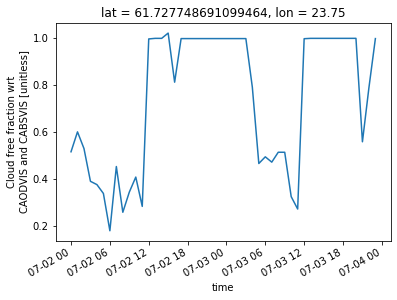

In [76]:
(_ds['CLDFREE']+_ds['CLDTOT']).sel(lat=lat_smr, lon = lon_smr, method = 'nearest').plot()

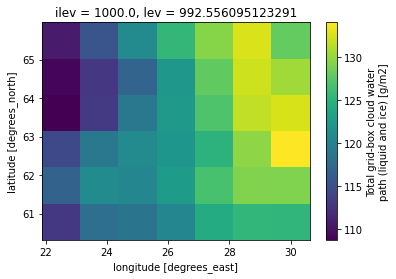

In [77]:
ds_all['TGCLDCWP_incld'].where(ds_all['CLDFREE']<.99).mean('time').plot()

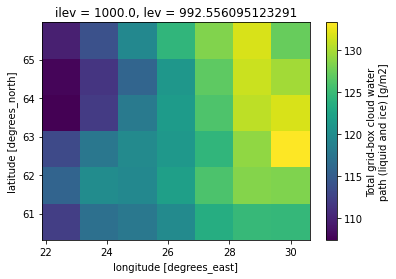

In [78]:
ds_all['TGCLDCWP_incld'].mean('time').plot()

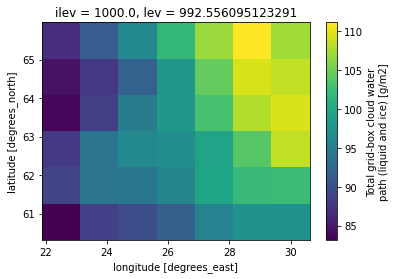

In [79]:
ds_all['TGCLDCWP'].mean('time').plot()

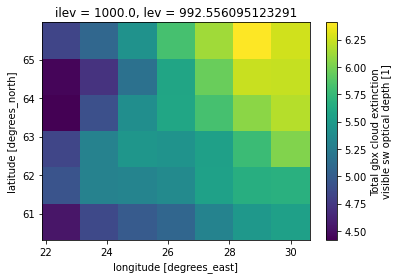

In [80]:
ds_all['TOT_CLD_VISTAU_s'].mean('time').plot()

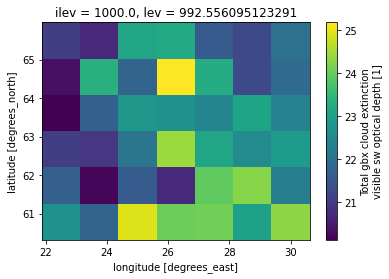

In [81]:
ds_all['TOT_CLD_VISTAU_s_incld'].where(ma).mean('time').plot()

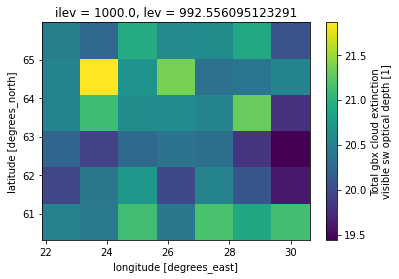

In [82]:
ds_all['TOT_CLD_VISTAU_s_incld'].where(ma).median('time').plot()